<a href="https://www.kaggle.com/code/vijayj0shi/avataar-projeccth1?scriptVersionId=199338857" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [22]:
!pip install diffusers transformers accelerate scipy safetensors

In [23]:
import PIL
import requests
import torch
from io import BytesIO

In [24]:
from diffusers import StableDiffusionInpaintPipeline

# Load the Stable Diffusion Inpainting Pipeline
This section loads the Stable Diffusion Inpainting pipeline and moves the model to the GPU (CUDA).
# Pipeline Model Details
This is a description of the Stable Diffusion pipeline's components, including feature extractors, encoders, and UNet model.



In [25]:

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float32,
)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Download an Image
A function to download an image from a given URL and convert it to RGB format using PIL.


In [26]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url ="/kaggle/input/avataar-example/Avataar_example/example1.jpg"
init_image = download_image(img_url)

# Create and Display the Object Mask
Now we apply the object mask to the initial image.


In [28]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
def create_object_mask(image):
    image_array = np.array(image)
    
   
    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)
    hsv_image = cv2.GaussianBlur( hsv_image, (3, 3), 0)
   
    lower_white = np.array([0, 0, 250], dtype=np.uint8)   # Lower bound for pure white
    upper_white = np.array([0, 0, 255], dtype=np.uint8)   # Upper bound for pure white
    
   
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)
    
    
    non_white_mask = cv2.bitwise_not(white_mask)
    
    
    object_image = cv2.bitwise_and(image_array, image_array, mask=non_white_mask)
    
    gray_image = cv2.cvtColor(object_image, cv2.COLOR_RGB2GRAY)
    
   
    _, binary_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    
    
    kernel = np.ones((3, 3), np.uint8)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=2)
    binary_mask = cv2.erode(binary_mask, kernel, iterations=2) 
    
    
   
    
    
    inverted_mask = cv2.bitwise_not(binary_mask)
    
   
    return Image.fromarray(inverted_mask).resize(image.size)

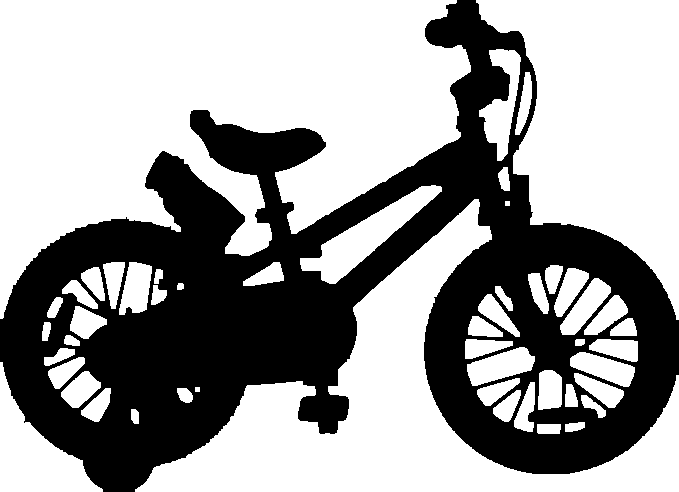

In [30]:
mask_image=create_object_mask(init_image)
mask_image

# Depth Estimation Using a Pretrained Model
This cell imports a depth estimation model from transformers, loads the model onto the GPU, and defines a function to generate depth maps for the input image.


In [31]:
# Import necessary libraries
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image


feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
depth_model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to("cuda")


def generate_depth_map(image):
    # Preprocess the input image
    inputs = feature_extractor(images=image, return_tensors="pt").to("cuda")
    
    
    with torch.no_grad():
        depth_output = depth_model(**inputs).predicted_depth
    
   
    depth_map = torch.nn.functional.interpolate(
        depth_output.unsqueeze(1), 
        size=image.size[::-1],  
        mode="bicubic",
        align_corners=False
    ).squeeze()

    
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
  
    depth_map_image = Image.fromarray((depth_map.cpu().numpy() * 255).astype(np.uint8))
    
    return depth_map_image





Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Depth Map Image Overlay Function
Here we overlay the mask image on the depth map for further composition.


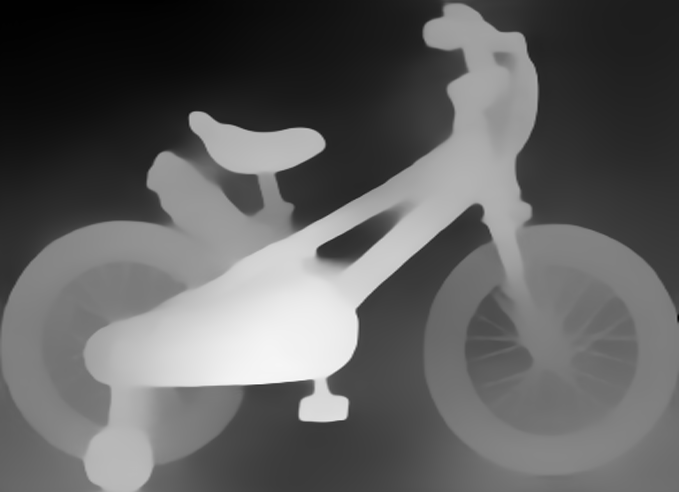

In [32]:

from PIL import Image
def depth_map_image_fun(mask_image,init_image):
    depth_map_image = generate_depth_map(init_image)
    background = depth_map_image
    overlay = mask_image

    overlay = overlay.resize(background.size)

    
    background.paste(overlay, (0, 0), overlay)
    return background


# Show the result
depth_map_image = generate_depth_map(init_image)
# depth_map_image=depth_map_image_fun(mask_image,init_image)
depth_map_image

# Image Inpainting and Depth Map Utilization
We perform image inpainting using a prompt, mask image, depth map, and a few hyperparameters for controlling the generation process.


  0%|          | 0/35 [00:00<?, ?it/s]

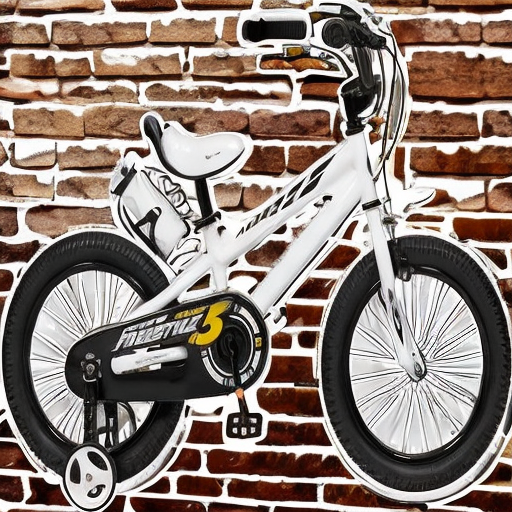

In [33]:
from PIL import Image
prompt ="A modern bicycle on road leaning against an old brown brick wall in natural sunlight ,real bicycle,harmonize, add depth using depth map ,smooth tires. The scene is calm and realistic with subtle shadows, and soft lighting. No other objects around, focusing entirely on the bike use depth map to harmonize the bicycle with background"

negative_prompt="No harsh lighting, no clutter no reflections, no unrealistic colors, no futuristic elements, no distorted shapes, no blurry objects, no floating items, no extreme highlights, no over-saturated colors, no chaotic composition,, no excessive details,do not change bicycle do not add extra part on  bicycle ."

num_inference_steps = 35  # Refined image generation steps
guidance_scale = 5.5      # Balance between creativity and prompt adherence
strength = 0.9            # Influence of the original image

# Generate inpainted image
new_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=init_image,
    mask_image=mask_image,
    depth_map=depth_map_image,
    num_inference_steps=num_inference_steps,
#   guidance_scale=guidance_scale,
#   strength=strength,
    height=512,
    width=512
).images[0]
new_image


# Display Image Properties
Finally, we check the properties of the images (initial, mask, and output).

In [34]:
print("Init Image Properties:")
print("Size:", init_image .size)
print("Mode:", init_image .mode)

# Check properties of output_image
print("mask Image Properties:")
print("Size:", mask_image .size)
print("Mode:", mask_image .mode)
print("Output Image Properties:")
print("Size:",new_image .size)
print("Mode:", new_image .mode)

Init Image Properties:
Size: (679, 492)
Mode: RGB
mask Image Properties:
Size: (679, 492)
Mode: L
Output Image Properties:
Size: (512, 512)
Mode: RGB


# Function to resize and center an image on a white background
 Takes an initial image and a scaling factor
 Returns a resized image with the item centered on a white       background


In [35]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
def resize_and_center_images(init_image, scale_factor=0.96):
    item_img = np.array(init_image) if isinstance(init_image, Image.Image) else init_image

    new_size = (int(item_img.shape[1] * scale_factor), int(item_img.shape[0] * scale_factor))
    resized_item = cv2.resize(item_img, new_size)

    background = np.ones_like(item_img) * 255

    start_x = (background.shape[1] - resized_item.shape[1]) // 2
    start_y = (background.shape[0] - resized_item.shape[0]) // 2

    
    background[start_y:start_y + resized_item.shape[0], start_x:start_x + resized_item.shape[1]] = resized_item
    resized_image=background

    return resized_image






# List of video prompts that describe various item scenes
#  Each prompt is used to generate an image with depth and harmonization effects


In [36]:
video_prompts = [
    "A vintage bicycle resting on a wooden pier, surrounded by calm water. Add depth using a depth map and smooth tires. The scene is serene, featuring gentle waves and soft sunlight reflecting on the water, harmonizing the bicycle with the tranquil background.", 
    "A bright red bicycle parked under a blooming cherry blossom tree. Add depth using a depth map and smooth tires. The atmosphere is peaceful, with delicate petals falling softly and subtle shadows playing on the ground, creating a harmonious background.",
    "A bicycle on a cobblestone street, illuminated by street lamps at dusk. Add depth using a depth map and smooth tires. The scene is nostalgic, with warm lights and gentle shadows enhancing the bicycle's details, harmonizing it with the charming street.",
    "A classic bicycle in a vibrant flower garden. Add depth using a depth map and smooth tires. The setting is cheerful and colorful, with various flowers around, creating a soft focus effect that harmonizes the bicycle with its beautiful surroundings.",
    "A bicycle against a rustic barn backdrop during golden hour. Add depth using a depth map and smooth tires. The scene is warm and inviting, with soft golden light bathing the bicycle and barn, enhancing the peaceful rural atmosphere.",
    "A bicycle on a mountain trail with lush greenery. Add depth using a depth map and smooth tires. The atmosphere is fresh and invigorating, with sunlight filtering through the trees and gentle shadows adding dimension to the scene.",
    "A bicycle parked beside a tranquil lake surrounded by mountains. Add depth using a depth map and smooth tires. The scene is serene, with calm waters reflecting the mountains, creating a peaceful harmony with the bicycle in focus.",
    "A bicycle on a rainy street, reflecting colorful lights. Add depth using a depth map and smooth tires. The scene is moody and atmospheric, with rain droplets creating a soft sheen on the ground, harmonizing the bicycle with its surroundings.",
    "A bicycle in a cozy coffee shop with large windows. Add depth using a depth map and smooth tires. The atmosphere is warm and inviting, with soft lighting illuminating the bicycle, creating a sense of calmness and harmony.",
    "A bicycle near a quaint bridge over a small stream. Add depth using a depth map and smooth tires. The setting is peaceful, with gentle water flow and greenery surrounding the bridge, harmonizing beautifully with the bicycle.",
    "A bicycle on a snowy path in a winter wonderland. Add depth using a depth map and smooth tires. The scene is magical, with soft snowflakes falling and subtle shadows enhancing the tranquil winter landscape around the bicycle.",
    "A bicycle resting on a grassy hill overlooking a city skyline. Add depth using a depth map and smooth tires. The atmosphere is expansive and vibrant, with the sunset casting a warm glow over the city, harmonizing with the bicycle's position.",
    "A bicycle by an old stone fountain in a quiet plaza. Add depth using a depth map and smooth tires. The scene is tranquil, with the sound of water and gentle sunlight filtering through trees, creating a peaceful harmony with the bicycle.",
    "A bicycle on a narrow path through a dense forest. Add depth using a depth map and smooth tires. The atmosphere is enchanting, with dappled sunlight breaking through leaves, enhancing the natural beauty and harmonizing the bicycle with the setting.",
    "A bicycle parked in front of a colorful mural on a brick wall. Add depth using a depth map and smooth tires. The scene is vibrant and artistic, with bright colors creating a lively background that harmonizes with the bicycle."
]

video_negative_prompt="No harsh lighting, no clutter,  no reflections, no unrealistic colors, no futuristic elements, no distorted shapes, no blurry objects, no floating items, no extreme highlights, no over-saturated colors, no chaotic composition,, no excessive details,do not change bicycle do not add extra part on  bicycle ."


# Function to create video frames based on prompts and depth maps
Generates images for each prompt, applies scaling, and appends frames to a list
Handles both original and resized images


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

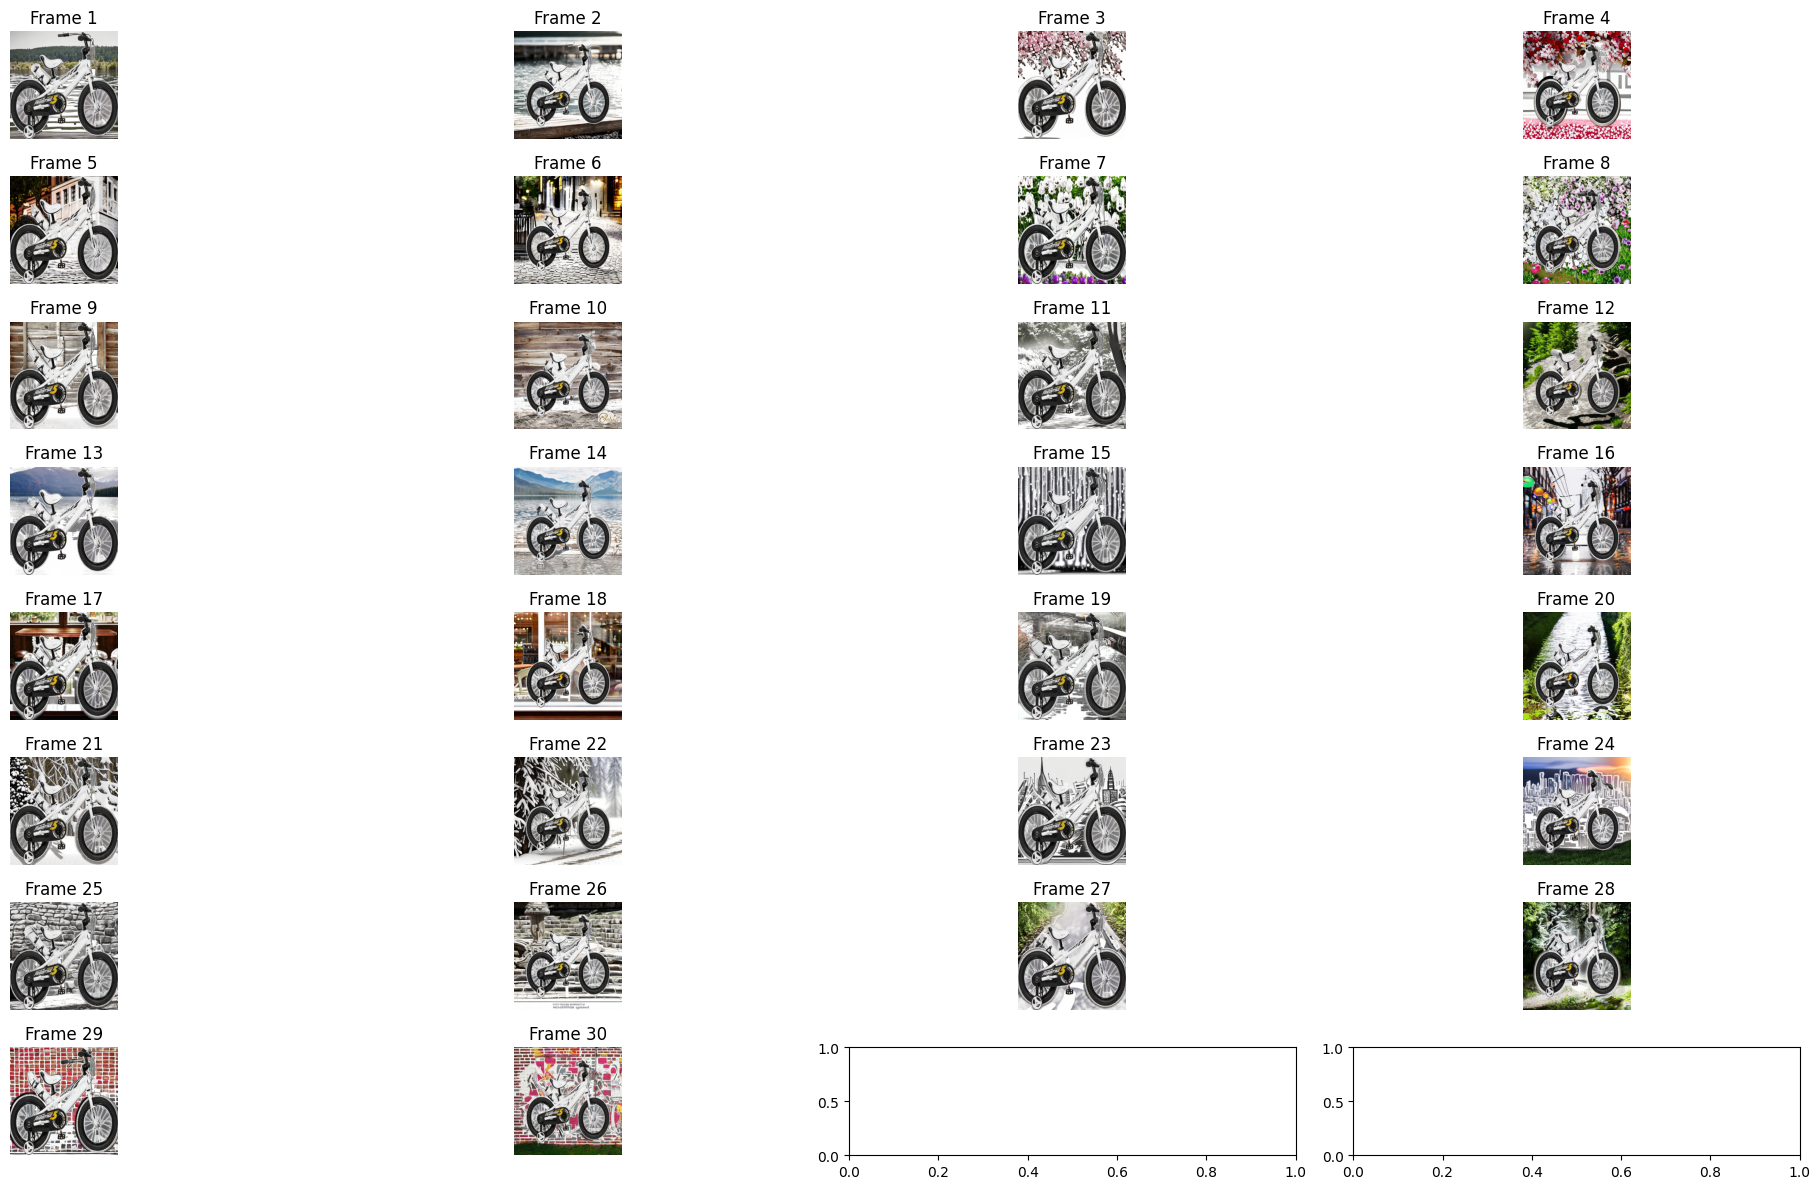

In [37]:
import cv2
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# Updated function to handle multiple prompts
def frame_creation(init_image, prompts, negative_prompt, scale_factor=0.77):
    frames = []
    guidance_scale = 7.5     
    strength = 0.9   

    for prompt in prompts:
      
        scaled_image = init_image
        
        if isinstance(scaled_image, np.ndarray):
            scaled_image = Image.fromarray(scaled_image)

        # Apply inpainting with the original size for the current prompt
        mask_image_resized = create_object_mask(scaled_image)
        depth_map_resized=generate_depth_map(scaled_image)
        new_image_original = pipe(
            prompt=prompt, 
            negative_prompt=negative_prompt,
            image=scaled_image, 
            depth_map=depth_map_resized,
            mask_image=mask_image_resized, 
            num_inference_steps=55,
            guidance_scale=guidance_scale,
#             strength=strength,
            height=512,
            width=512
        ).images[0]
        

        frames.append(cv2.cvtColor(np.array(new_image_original), cv2.COLOR_RGB2BGR))

        
        scaled_image = resize_and_center_images(init_image, scale_factor)

        if isinstance(scaled_image, np.ndarray):
            scaled_image = Image.fromarray(scaled_image)

     
        mask_image_resized = create_object_mask(scaled_image)
        new_image_resized = pipe(
            prompt=prompt, 
            negative_prompt=negative_prompt,
            image=scaled_image,
            depth_map=depth_map_resized,             
            mask_image=mask_image_resized, 
            num_inference_steps=55,
            guidance_scale=guidance_scale,
#            strength=strength
            height=512,
            width=512
        ).images[0]
        
        frames.append(cv2.cvtColor(np.array(new_image_resized), cv2.COLOR_RGB2BGR))
    
    return frames

frames = frame_creation(init_image, video_prompts, video_negative_prompt, scale_factor=0.77)


num_frames = len(frames)

rows = (num_frames // cols) + (1 if num_frames % cols else 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
axes = axes.flatten()

for i, frame in enumerate(frames): 
    axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  
    axes[i].axis('off')
    axes[i].set_title(f'Frame {i+1}')

plt.tight_layout()
plt.show()


# Function to save generated frames into a video file
Uses OpenCV to write frames to a video file with the specified frame rate (fps)
 Ensures all frames are resized to a consistent target size

In [38]:

def save_frames_to_video(frames, output_path, fps=1, target_size=(512, 512)):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, target_size)

    for frame in frames:
        video_frame = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR)
        video_writer.write(cv2.resize(video_frame, target_size))  

    video_writer.release()



# Save the generated frames into a video file
 Display a link to download the video


In [39]:
output_video_path = "output_video_3oct_evening.mp4"  h
save_frames_to_video(frames, output_video_path, fps=1)
print(f"Video saved at {output_video_path}")
from IPython.display import FileLink

FileLink(output_video_path)#

Video saved at output_video_3oct_evening.mp4


/kaggle/working/output_video_3oct_evening.mp4